## Import some helpful libraries

In [1]:
print("    Version control\n------------------------")
import os     # operating system interfaces
import fnmatch
import random
import datetime
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
from nibabel.testing import data_path
import math
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import sys
import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras;                    print("Keras\t\t {}".format(keras.__version__))
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv3DTranspose, MaxPooling3D, UpSampling3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.3.1
Keras		 2.3.1


Using TensorFlow backend.


## Loading Dataset: Training and Validation Datasets (randomly)

In [3]:
## Loading dataset from path directory
print(os.getcwd())     # '/Users/shossein/GitHub/DTI_Clustering'

## load train data
sample_train_subset = np.loadtxt("train_100_sample_name.csv", dtype=str, delimiter=",")
train_data = np.load('train_100.npy').reshape(100,182,218,182,1)
print('train_data shape is {}'.format(train_data.shape))

## load validation data
sample_val_subset = np.loadtxt("valid_24_sample_name.csv", dtype=str, delimiter=",")
valid_data = np.load('valid_24.npy').reshape(24,182,218,182,1)
print('valid_data shape is {}'.format(valid_data.shape))

/Users/shossein/GitHub/DTI_Clustering
train_data shape is (100, 182, 218, 182, 1)
valid_data shape is (24, 182, 218, 182, 1)


In [7]:
print("There are", len(sample_train_subset), " subset of train samples are:\n")
print(*sample_train_subset, sep='\t')
print("\n--------------------------------------------------------------------------------\n")
print("There are", len(sample_val_subset), " subset of Validation samples are:\n")
print(*sample_val_subset, sep='\t')

There are 100  subset of train samples are:

Pat_100_1-post.nii.gz	Pat_101_1-post.nii.gz	Pat_102_1-post.nii.gz	Pat_103_1-post.nii.gz	Pat_107_1-post.nii.gz	Pat_108_1-post.nii.gz	Pat_109_1-post.nii.gz	Pat_110_1-post.nii.gz	Pat_114_1-post.nii.gz	Pat_115_1-post.nii.gz	Pat_116_1-post.nii.gz	Pat_117_1-post.nii.gz	Pat_118_1-post.nii.gz	Pat_11_1-post.nii.gz	Pat_121_1-post.nii.gz	Pat_122_1-post.nii.gz	Pat_123_1-post.nii.gz	Pat_126_1-post.nii.gz	Pat_127_1-post.nii.gz	Pat_129_1-post.nii.gz	Pat_12_1-post.nii.gz	Pat_130_1-post.nii.gz	Pat_131_1-post.nii.gz	Pat_132_1-post.nii.gz	Pat_135_1-post.nii.gz	Pat_137_1-post.nii.gz	Pat_138_1-post.nii.gz	Pat_139_1-post.nii.gz	Pat_13_1-post.nii.gz	Pat_140_1-post.nii.gz	Pat_141_1-post.nii.gz	Pat_142_1-post.nii.gz	Pat_143_1-post.nii.gz	Pat_144_1-post.nii.gz	Pat_145_1-post.nii.gz	Pat_15_1-post.nii.gz	Pat_16_1-post.nii.gz	Pat_17_1-post.nii.gz	Pat_18_1-post.nii.gz	Pat_19_1-post.nii.gz	Pat_21_1-post.nii.gz	Pat_22_1-post.nii.gz	Pat_23_1-post.nii.gz	Pat_24_1-post.nii.gz

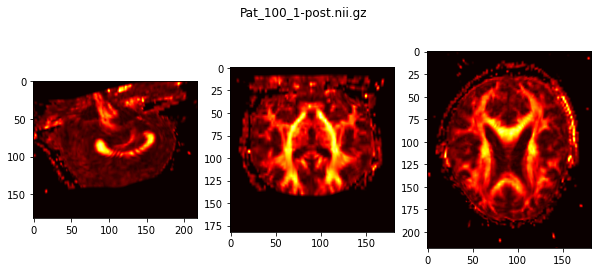

In [8]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray
        
# for m in range(train_data.shape[0]):
for m in range(1):
    slice_0 = train_data[m, 91, :, :, 0]
    slice_1 = train_data[m, :, 109, :, 0]
    slice_2 = train_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

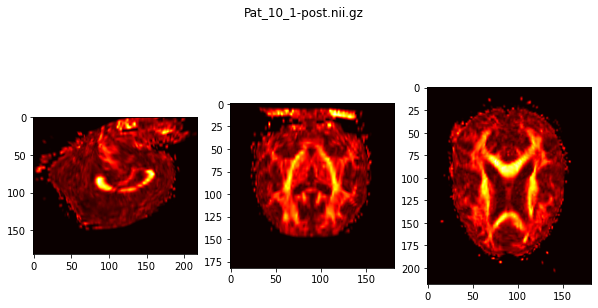

In [9]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

# for m in range(valid_data.shape[0]):
for m in range(1):
    slice_0 = valid_data[m, 91, :, :, 0]
    slice_1 = valid_data[m, :, 109, :, 0]
    slice_2 = valid_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val_subset[m], x=0.5, y=1)

## Model Design

In [10]:
## Define parameters:

IMAGE_HEIGHT = train_data.shape[1]
IMAGE_WIDTH = train_data.shape[2]
IMAGE_DEPTH = train_data.shape[3]
batch_size = 1
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("input-layer shape:", input_shape)

## Encoder
input_img = Input(shape=(182, 218, 182, 1))
x = Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', name='Conv1')(input_img)
x = MaxPooling3D(pool_size=(13, 13, 13), padding='same')(x)
x = Conv3D(filters=8, kernel_size=(3, 3, 3), padding='same', activation='relu', name='Conv2')(x)
encoded = MaxPooling3D(pool_size=(7, 7, 7), padding='same')(x)
## at this point the representation is (2, 3, 2, 8) i.e. 96-dimensional instead of 7,221,032

## Decoder
x = Conv3DTranspose(filters=4, kernel_size=(3, 3, 3), padding='same', activation='relu', name='DeConv3')(encoded)
x = UpSampling3D(size=(7, 6, 7))(x)
x = Conv3DTranspose(filters=8, kernel_size=(3, 3, 3), padding='same', activation='relu', name='DeConv4')(x)
x = UpSampling3D(size=(13, 12, 13))(x)
decoded = Conv3DTranspose(filters=1, kernel_size=(1, 3, 1), padding='valid', activation='sigmoid', name='DeConv5')(x)

autoencoder = Model(inputs=input_img, outputs=decoded)
# autoencoder.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

input-layer shape: [1, 182, 218, 182, 1]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 182, 218, 182, 16) 448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 17, 14, 16)    0         
_________________________________________________________________
Conv2 (Conv3D)               (None, 14, 17, 14, 8)     3464      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 3, 2, 8)        0         
_________________________________________________________________
DeConv3 (Conv3DTranspose)    (None, 2, 3, 2, 4)        868       
_________________________________________________________________
up_sampling3d

## Model Training

In [11]:
## Tensorboard

%load_ext tensorboard
# %reload_ext tensorboard
logdir = os.path.join("CAE_logs", datetime.datetime.now().strftime("%Y_%m_%d____%H_%M_%S"))
tb_callback = TensorBoard(logdir, histogram_freq=1)

In [12]:
## Midel Fit
autoencoder.fit(train_data, train_data, epochs=3, batch_size=batch_size, shuffle=True, steps_per_epoch=5, validation_data=(valid_data, valid_data), callbacks=[tb_callback], verbose=1)
autoencoder.save_weights("CAE_weights.hdf5")
# autoencoder.load_weights("CAE_weights.hdf5")     # loading weights

Epoch 1/3
1/5 [=====>........................] - ETA: 0s - loss: 0.7040 - accuracy: 0.2082WARNING:tensorflow:From /Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5/5 [==============================] - 106s 21s/step - loss: 0.6898 - accuracy: 0.4790 - val_loss: 0.6734 - val_accuracy: 0.7057
Epoch 2/3
5/5 [==============================] - 104s 21s/step - loss: 0.6512 - accuracy: 0.6722 - val_loss: 0.6010 - val_accuracy: 0.7061
Epoch 3/3
5/5 [==============================] - 98s 20s/step - loss: 0.5367 - accuracy: 0.6993 - val_loss: 0.4168 - val_accuracy: 0.7062


In [13]:
tensorboard --logdir=CAE_logs

Reusing TensorBoard on port 6006 (pid 93111), started 1:26:44 ago. (Use '!kill 93111' to kill it.)